# Forager

An agent that has competing drives - hide in a safe area or traverse risky territory to visit food, which resets hunger. Hunger increases at each timestep that it isn't visiting food.

In [110]:
%pip install inferactively-pymdp

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports

In [111]:
import os
import sys
import pathlib
import numpy as np

from pymdp.agent import Agent
from pymdp import utils, maths

# Task
Develop and analyze an active inference agent for a camping and foraging task within a custom grid world environment. This involves:

1.  **Environment Setup**: Defining a `4x4` grid with 'food' at `(0,3)` and 'shelter' at `(0,0)`, a maximum hunger level of `5`, and a maximum risk level of `5`.
2.  **Generative Model Design** (Using **Factorized State Space** with `B_factor_list`):
    *   **Hidden State Factors**: `Location` (16 grid points), `Hunger Level` (0-5), and `Risk Level` (0-5) as **separate factors**.
    *   **Observations**: `Location Observation`, `Hunger Sensor`, and `Risk Sensor`.
    *   **`A` Matrix**: Multi-dimensional arrays mapping states to observations, with location-dependent perception (satiated at food, safe at shelter).
    *   **`B` Matrix** with **`B_factor_list`**: 
        - `B[0]` (Location): Standard 5-action movement, depends only on Location.
        - `B[1]` (Hunger): **Location-dependent** transitions via `B_factor_list=[[0], [0,1], [0,2]]` - resets at food, otherwise increases.
        - `B[2]` (Risk): **Location-dependent** transitions - resets at shelter, otherwise increases.
    *   **`C` Vector**: Preferences for low hunger and low risk observations.
    *   **`D` Vector**: Initial belief of starting location with hunger 0 and risk 0.
3.  **Generative Process (`GridWorldEnv`)**: Implementing a custom class that simulates true environment dynamics.
4.  **Simulation & Analysis**: Running a simulation, tracking the agent's path, hunger, and risk, visualizing the results.

**Key Advantage**: Factorized state space with `B_factor_list` scales as O(n) instead of O(n³), making larger grids and longer policy horizons tractable.

## Define Environment Parameters

### Subtask:
Establish the grid dimensions, specific locations for 'food' and 'shelter' squares, a maximum hunger level, and how risk factors will be assigned to non-shelter squares. Also define the mapping of linear indices to (y,x) coordinates for the grid.


**Reasoning**:
The user provided specific instructions for defining the environment parameters, including grid dimensions, food/shelter locations, max hunger, and risk factors. I will generate the Python code to set up these parameters as specified.



In [112]:
# Scalable grid world configuration
grid_dims = [5, 5]  # 5x5 grid (25 locations)
max_hunger = 7      # 0-7 (8 levels)
max_risk = 7        # 0-7 (8 levels)

# Food and shelter are 8 steps apart along the diagonal
shelter_location = (0, 0) # Top-left corner
food_location = (4, 0)    # Bottom-left corner

num_grid_points = int(np.prod(grid_dims))  # 25 grid locations

# Create a look-up table `loc_list` that maps linear indices to (y, x) coordinates
grid = np.arange(num_grid_points).reshape(grid_dims)
it = np.nditer(grid, flags=["multi_index"])

loc_list = []
while not it.finished:
    loc_list.append(it.multi_index)
    it.iternext()

distance = abs(food_location[0]-shelter_location[0]) + abs(food_location[1]-shelter_location[1])

print(f"Grid Dimensions: {grid_dims}")
print(f"Maximum Hunger/Risk Level: {max_hunger}")
print(f"Food Location: {food_location}")
print(f"Shelter Location: {shelter_location}")
print(f"Manhattan distance: {distance} steps")
print(f"\nFactorized state space:")
print(f"  {num_grid_points} locations + {max_hunger+1} hunger + {max_risk+1} risk = {num_grid_points + max_hunger+1 + max_risk+1} parameters")
print(f"  (vs unified: {num_grid_points * (max_hunger+1) * (max_risk+1)} states)")
print(f"\n*** Journey ({distance} steps) < Max level ({max_hunger}) = Agent survives! ***")

Grid Dimensions: [5, 5]
Maximum Hunger/Risk Level: 7
Food Location: (4, 0)
Shelter Location: (0, 0)
Manhattan distance: 4 steps

Factorized state space:
  25 locations + 8 hunger + 8 risk = 41 parameters
  (vs unified: 1600 states)

*** Journey (4 steps) < Max level (7) = Agent survives! ***


## Define Hidden State Factors

### Subtask:
Specify the agent's hidden state factors (`num_states`). You will need three factors: 1) Location (the agent's position in the grid), 2) Hunger Level (discrete levels from 0 to `max_hunger`), and 3) Risk Level (discrete levels from 0 to `max_risk`).

#### Instructions
1. Define `hunger_levels` and `risk_levels` as NumPy arrays ranging from 0 to their respective max values.
2. Create `num_states = [num_grid_points, num_hunger, num_risk]` as **three separate factors** (not unified).
3. This factorized representation scales linearly O(n) instead of O(n³) with the unified approach.

**Reasoning**:
Using a **factorized state space** with `B_factor_list` instead of a unified state space. This keeps Location, Hunger, and Risk as separate factors while still allowing location-dependent dynamics through the transition model dependencies.

In [113]:
hunger_levels = np.arange(max_hunger + 1)  # 0 to max_hunger, inclusive
risk_levels = np.arange(max_risk + 1)  # 0 to max_risk, inclusive

# Pre-compute indices for special locations
food_idx = loc_list.index(food_location)
shelter_idx = loc_list.index(shelter_location)

# FACTORIZED STATE SPACE: Keep Location, Hunger, Risk as separate factors
# Use B_factor_list to encode location-dependent transitions for hunger/risk
num_hunger = len(hunger_levels)
num_risk = len(risk_levels)

# Hidden state factors: [Location, Hunger, Risk]
num_states = [num_grid_points, num_hunger, num_risk]

print(f"Factorized State Space:")
print(f"  Factor 0 (Location): {num_grid_points} states")
print(f"  Factor 1 (Hunger): {num_hunger} states (0-{max_hunger})")
print(f"  Factor 2 (Risk): {num_risk} states (0-{max_risk})")
print(f"  Total: {num_grid_points} + {num_hunger} + {num_risk} = {sum(num_states)} parameters")
print(f"  (vs unified: {num_grid_points * num_hunger * num_risk} states)")
print(f"\nFood at index {food_idx} {food_location}, Shelter at index {shelter_idx} {shelter_location}")

Factorized State Space:
  Factor 0 (Location): 25 states
  Factor 1 (Hunger): 8 states (0-7)
  Factor 2 (Risk): 8 states (0-7)
  Total: 25 + 8 + 8 = 41 parameters
  (vs unified: 1600 states)

Food at index 20 (4, 0), Shelter at index 0 (0, 0)


## Define Observation Modalities

### Subtask:
Specify the agent's observation modalities (`num_obs`). You will need three modalities: 1) Location Observation (the agent observes its position), 2) Hunger Sensor (the agent observes its internal hunger state), and 3) Risk Sensor (the agent observes its internal risk state).

**Reasoning**:
I will define the names for each observation modality and then create the `num_obs` list based on their dimensionalities, as specified in the instructions. This will complete the subtask of specifying the observation modalities.



In [114]:
location_obs_names = [f"({y},{x})" for y,x in loc_list] # For Location Observation
hunger_sensor_names = ['satiated'] + [f'hunger_{h}' for h in range(1, max_hunger + 1)] # 'satiated' is hunger_0
risk_sensor_names = ['safe'] + [f'risk_{r}' for r in range(1, max_risk + 1)] # 'safe' is risk_0

# Observation modalities and their levels
num_obs = [
    num_grid_points, # Location Observation (number of grid points)
    len(hunger_sensor_names), # Hunger Sensor (satiated, hunger_1, ..., hunger_max_hunger)
    len(risk_sensor_names) # Risk Sensor (safe, risk_1, ..., risk_max_risk)
]

print(f"Observation Dimensionalities (Location, Hunger Sensor, Risk Sensor): {num_obs}")
print(f"Hunger Sensor Names: {hunger_sensor_names}")
print(f"Risk Sensor Names: {risk_sensor_names}")

Observation Dimensionalities (Location, Hunger Sensor, Risk Sensor): [25, 8, 8]
Hunger Sensor Names: ['satiated', 'hunger_1', 'hunger_2', 'hunger_3', 'hunger_4', 'hunger_5', 'hunger_6', 'hunger_7']
Risk Sensor Names: ['safe', 'risk_1', 'risk_2', 'risk_3', 'risk_4', 'risk_5', 'risk_6', 'risk_7']


## Design Observation Model (A matrix)

### Subtask:
Construct the `A` matrix, paying close attention to dependencies for each observation modality.


**Reasoning**:
For the factorized state space, each A matrix has shape `(num_obs[m], num_states[0], num_states[1], num_states[2])`, i.e., observation dimension × all state factor dimensions. This allows observations to depend on any combination of hidden state factors.

In [115]:
# A matrix shapes for factorized state space:
# Each A[m] has shape (num_obs[m], num_states[0], num_states[1], num_states[2])
# i.e., (num_obs[m], num_locations, num_hunger, num_risk)

A_m_shapes = [[num_obs[m]] + num_states for m in range(len(num_obs))]
A = utils.obj_array_zeros(A_m_shapes)

print(f"Building A matrices for factorized state space...")
print(f"  A[0] Location obs shape: {A[0].shape}")
print(f"  A[1] Hunger sensor shape: {A[1].shape}")
print(f"  A[2] Risk sensor shape: {A[2].shape}")

# Fill A matrices
for loc_idx in range(num_grid_points):
    for h in range(num_hunger):
        for r in range(num_risk):
            # A[0] - Location Observation: identity mapping for location
            A[0][loc_idx, loc_idx, h, r] = 1.0
            
            # A[1] - Hunger Sensor
            # At food: always observe 'satiated' (index 0)
            # Elsewhere: observe true hunger level
            if loc_idx == food_idx:
                A[1][0, loc_idx, h, r] = 1.0  # Always satiated at food
            else:
                A[1][h, loc_idx, h, r] = 1.0  # True hunger elsewhere
            
            # A[2] - Risk Sensor
            # At shelter: always observe 'safe' (index 0)
            # Elsewhere: observe true risk level
            if loc_idx == shelter_idx:
                A[2][0, loc_idx, h, r] = 1.0  # Always safe at shelter
            else:
                A[2][r, loc_idx, h, r] = 1.0  # True risk elsewhere

print("\nAll A matrices filled.")
print("  Food location -> always 'satiated' observation")
print("  Shelter location -> always 'safe' observation")

# Verification: check normalization
all_normalized = True
for m in range(len(A)):
    # Sum over observation dimension (axis 0) should be 1 for all state configs
    sum_over_obs = A[m].sum(axis=0)
    is_norm_m = np.allclose(sum_over_obs, 1.0)
    if not is_norm_m:
        print(f"Warning: A[{m}] is NOT normalized!")
        all_normalized = False
print(f"All A sub-arrays are normalized: {all_normalized}")

Building A matrices for factorized state space...
  A[0] Location obs shape: (25, 25, 8, 8)
  A[1] Hunger sensor shape: (8, 25, 8, 8)
  A[2] Risk sensor shape: (8, 25, 8, 8)

All A matrices filled.
  Food location -> always 'satiated' observation
  Shelter location -> always 'safe' observation
All A sub-arrays are normalized: True


## Design Transition Model (B matrix)

### Subtask:
Construct the `B` matrix using **`B_factor_list`** to encode location-dependent dynamics while keeping the state space factorized.

#### Key Concept: B_factor_list
The `B_factor_list` parameter specifies which hidden state factors each transition matrix depends on:
- `B_factor_list = [[0], [0, 1], [0, 2]]` means:
  - `B[0]` (Location) depends only on Location (factor 0) - standard movement
  - `B[1]` (Hunger) depends on Location AND Hunger - **location-dependent transitions!**
  - `B[2]` (Risk) depends on Location AND Risk - **location-dependent transitions!**

This allows encoding that:
- Hunger resets to 0 when at the food location
- Risk resets to 0 when at the shelter location

...while keeping the state space factorized (scalable).

**Reasoning**:
With the factorized approach:
- `num_controls = [5, 1, 1]` - Location has 5 movement actions, Hunger and Risk have 1 null action each (uncontrollable)
- `B_factor_list = [[0], [0, 1], [0, 2]]` - specifies dependencies for location-dependent dynamics
- `control_fac_idx = [0]` - only Location factor is under agent's control

B matrix shapes follow the pattern: `(next_state, *parent_factor_dims, num_actions)`
- For B_factor_list[1] = [0, 1]: B[1] has shape `(6, 16, 6, 1)` = `(next_hunger, location, curr_hunger, 1 action)`
- For B_factor_list[2] = [0, 2]: B[2] has shape `(6, 16, 6, 1)` = `(next_risk, location, curr_risk, 1 action)`

In [116]:
# FACTORIZED TRANSITION MODEL
# num_controls: actions per factor - only Location (factor 0) is controllable
num_controls = [5, 1, 1]  # 5 movement actions, 1 null action for hunger, 1 null action for risk

# B_factor_list specifies which state factors each B matrix depends on:
# - B[0] (Location): depends only on Location (factor 0) - standard
# - B[1] (Hunger): depends on Location (factor 0) AND Hunger (factor 1) - location-dependent!
# - B[2] (Risk): depends on Location (factor 0) AND Risk (factor 2) - location-dependent!
B_factor_list = [[0], [0, 1], [0, 2]]

# Specify only Location (factor 0) is controllable by agent
control_fac_idx = [0]

# Initialize B matrices with appropriate shapes
# Shape pattern: (next_state, *parent_factor_dims, num_actions)
# For B_factor_list = [[0], [0, 1], [0, 2]]:
# B[0]: (16, 16, 5) - next_loc, curr_loc, 5 actions
# B[1]: (6, 16, 6, 1) - next_hunger, curr_loc (factor 0), curr_hunger (factor 1), 1 null action
# B[2]: (6, 16, 6, 1) - next_risk, curr_loc (factor 0), curr_risk (factor 2), 1 null action

B = utils.obj_array(len(num_states))
B[0] = np.zeros((num_grid_points, num_grid_points, num_controls[0]))  # (16, 16, 5)
B[1] = np.zeros((num_hunger, num_grid_points, num_hunger, num_controls[1]))  # (6, 16, 6, 1)
B[2] = np.zeros((num_risk, num_grid_points, num_risk, num_controls[2]))  # (6, 16, 6, 1)

print("B matrices initialized for factorized state space:")
print(f"  B[0] Location: {B[0].shape} - depends on [Location]")
print(f"  B[1] Hunger: {B[1].shape} - depends on [Location, Hunger]")
print(f"  B[2] Risk: {B[2].shape} - depends on [Location, Risk]")
print(f"\nB_factor_list: {B_factor_list}")
print(f"control_fac_idx: {control_fac_idx}")

B matrices initialized for factorized state space:
  B[0] Location: (25, 25, 5) - depends on [Location]
  B[1] Hunger: (8, 25, 8, 1) - depends on [Location, Hunger]
  B[2] Risk: (8, 25, 8, 1) - depends on [Location, Risk]

B_factor_list: [[0], [0, 1], [0, 2]]
control_fac_idx: [0]


#### Instructions
1. Fill out `B[0]` (Location transitions):
    * Iterate through each of the 5 possible actions (UP, DOWN, LEFT, RIGHT, STAY).
    * For each action and current location, calculate the next location based on grid boundaries.
    * Set `B[0][next_loc, curr_loc, action_id] = 1.0` for deterministic transitions.

**Reasoning**:
Filling `B[0]` with standard grid movement transitions. This factor only depends on itself (not on hunger or risk), which is reflected in `B_factor_list[0] = [0]`.

In [117]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

print("Filling B[0] - Location transitions...")

# B[0]: Location factor transitions based on movement actions
for action_id, action_label in enumerate(actions):
    for curr_loc_idx in range(num_grid_points):
        curr_y, curr_x = loc_list[curr_loc_idx]
        
        # Compute next location based on action
        if action_label == "UP":
            next_y = curr_y - 1 if curr_y > 0 else curr_y
            next_x = curr_x
        elif action_label == "DOWN":
            next_y = curr_y + 1 if curr_y < (grid_dims[0]-1) else curr_y
            next_x = curr_x
        elif action_label == "LEFT":
            next_y = curr_y
            next_x = curr_x - 1 if curr_x > 0 else curr_x
        elif action_label == "RIGHT":
            next_y = curr_y
            next_x = curr_x + 1 if curr_x < (grid_dims[1]-1) else curr_x
        elif action_label == "STAY":
            next_y, next_x = curr_y, curr_x
        
        next_loc = (next_y, next_x)
        next_loc_idx = loc_list.index(next_loc)
        
        # Set transition probability
        B[0][next_loc_idx, curr_loc_idx, action_id] = 1.0

print("B[0] Location transitions complete!")
print(f"  Actions: {actions}")

# Verify normalization
for action_id in range(5):
    col_sums = B[0][:, :, action_id].sum(axis=0)
    if not np.allclose(col_sums, 1.0):
        print(f"  Warning: B[0][:,:,{action_id}] not normalized!")
print("  B[0] verified: all columns sum to 1")

Filling B[0] - Location transitions...
B[0] Location transitions complete!
  Actions: ['UP', 'DOWN', 'LEFT', 'RIGHT', 'STAY']
  B[0] verified: all columns sum to 1


#### Instructions
1. Fill out `B[1]` (Hunger transitions) - **Location-dependent**:
    * Shape: `(num_hunger, num_hunger, num_locations, 1)` - depends on both location and hunger.
    * At food location: hunger resets to 0 regardless of current hunger.
    * Elsewhere: hunger increases by 1, capped at `max_hunger`.
2. Fill out `B[2]` (Risk transitions) - **Location-dependent**:
    * Shape: `(num_risk, num_risk, num_locations, 1)` - depends on both location and risk.
    * At shelter location: risk resets to 0 regardless of current risk.
    * Elsewhere: risk increases by 1, capped at `max_risk`.

**Reasoning**:
This is where `B_factor_list` enables the key behavior:
- `B[1]` has shape that includes the location dimension, allowing hunger to reset specifically at the food location.
- `B[2]` similarly depends on location, allowing risk to reset at the shelter.
This achieves location-dependent dynamics while keeping the state space factorized!

In [118]:
# B[1] - Hunger transitions: LOCATION-DEPENDENT!
# Shape: (num_hunger, num_locations, num_hunger, 1 null action)
# Indexed as: B[1][next_hunger, location, curr_hunger, action]
# - At food location: hunger resets to 0
# - Elsewhere: hunger increases by 1 (capped at max)

print("Filling B[1] - Hunger transitions (location-dependent)...")

for loc_idx in range(num_grid_points):
    for curr_hunger in range(num_hunger):
        if loc_idx == food_idx:
            # AT FOOD: hunger resets to 0 regardless of current hunger
            next_hunger = 0
        else:
            # ELSEWHERE: hunger increases by 1, capped at max
            next_hunger = min(curr_hunger + 1, max_hunger)
        
        # Single null action (action_id=0)
        B[1][next_hunger, loc_idx, curr_hunger, 0] = 1.0

print(f"  At food (loc {food_idx}): hunger -> 0")
print(f"  Elsewhere: hunger -> min(hunger+1, {max_hunger})")

# B[2] - Risk transitions: LOCATION-DEPENDENT!
# Shape: (num_risk, num_locations, num_risk, 1 null action)
# Indexed as: B[2][next_risk, location, curr_risk, action]
# - At shelter location: risk resets to 0
# - Elsewhere: risk increases by 1 (capped at max)

print("\nFilling B[2] - Risk transitions (location-dependent)...")

for loc_idx in range(num_grid_points):
    for curr_risk in range(num_risk):
        if loc_idx == shelter_idx:
            # AT SHELTER: risk resets to 0 regardless of current risk
            next_risk = 0
        else:
            # ELSEWHERE: risk increases by 1, capped at max
            next_risk = min(curr_risk + 1, max_risk)
        
        # Single null action (action_id=0)
        B[2][next_risk, loc_idx, curr_risk, 0] = 1.0

print(f"  At shelter (loc {shelter_idx}): risk -> 0")
print(f"  Elsewhere: risk -> min(risk+1, {max_risk})")

# Verify all B matrices
print("\nVerifying B matrix normalization...")
for f, factor_name in enumerate(['Location', 'Hunger', 'Risk']):
    # Check that columns sum to 1 for all control/parent configurations
    B_f = B[f]
    # Sum over first axis (next state)
    total_axes = tuple(range(1, len(B_f.shape)))  # All axes except the first
    for idx in np.ndindex(B_f.shape[1:]):
        col_sum = B_f[(slice(None),) + idx].sum()
        if not np.isclose(col_sum, 1.0):
            print(f"  Warning: B[{f}] column at {idx} sums to {col_sum:.3f}")
print("All B matrices verified!")

print("\n=== FACTORIZED DYNAMICS SUMMARY ===")
print(f"Location transitions: standard grid movement (5 actions)")
print(f"Hunger transitions: +1 per step, reset to 0 at food {food_location}")
print(f"Risk transitions: +1 per step, reset to 0 at shelter {shelter_location}")

Filling B[1] - Hunger transitions (location-dependent)...
  At food (loc 20): hunger -> 0
  Elsewhere: hunger -> min(hunger+1, 7)

Filling B[2] - Risk transitions (location-dependent)...
  At shelter (loc 0): risk -> 0
  Elsewhere: risk -> min(risk+1, 7)

Verifying B matrix normalization...
All B matrices verified!

=== FACTORIZED DYNAMICS SUMMARY ===
Location transitions: standard grid movement (5 actions)
Hunger transitions: +1 per step, reset to 0 at food (4, 0)
Risk transitions: +1 per step, reset to 0 at shelter (0, 0)


## Prior Preferences (C vector)

### Subtask:
Define the agent's prior preferences (`C` vector). This involves setting high positive preferences for observations associated with well-being (e.g., low hunger, low risk) and high negative preferences for observations associated with undesirable states (e.g., high hunger, high risk).

#### Instructions
1. Initialize the `C` vector as an object array with all zeros, using `utils.obj_array_zeros` and `num_obs`.
2. Set preferences for the `Hunger Sensor` observation modality (`C[1]`):
    * Assign a high positive value to `'satiated'` (hunger 0).
    * Assign moderate positive values to low hunger levels.
    * Assign negative values to moderate hunger levels.
    * Assign a high negative value to `max_hunger`.
3. Set preferences for the `Risk Sensor` observation modality (`C[3]`):
    * Use the same preference distribution as hunger - positive for 'safe', increasingly negative for higher risk levels.

**Reasoning**:
I will now initialize the `C` vector and set the preferences for the `Hunger Sensor` and `Risk Feedback` observation modalities, as per the instructions in the previous markdown block.



In [119]:
C = utils.obj_array_zeros(num_obs)

# Define key preference values
reward_satiated = 10.0
penalty_max = -50.0
penalty_approach = -8.0

# Hunger preferences
# Scale preferences automatically based on number of hunger levels
n_hunger = len(C[1])

C[1][0] = reward_satiated    # satiated - good reward
C[1][-1] = penalty_max       # max hunger - CATASTROPHIC!

# Intermediate levels: Quadratic scaling from 0 to penalty_approach
# Map indices 1 to n_hunger-2 to 0 to -8.0
if n_hunger > 2:
    for i in range(1, n_hunger - 1):
        # Normalize i from 0 (at i=1) to 1 (at i=n_hunger-2)
        denominator = (n_hunger - 2) - 1
        progress = (i - 1) / denominator if denominator > 0 else 1.0
        
        C[1][i] = penalty_approach * (progress ** 2)

# Risk preferences - symmetric with hunger
n_risk = len(C[2])

C[2][0] = reward_satiated    # safe - good reward
C[2][-1] = penalty_max       # max risk - CATASTROPHIC!

if n_risk > 2:
    for i in range(1, n_risk - 1):
        denominator = (n_risk - 2) - 1
        progress = (i - 1) / denominator if denominator > 0 else 1.0
        
        C[2][i] = penalty_approach * (progress ** 2)

print("C (prior preferences) vector filled.")
print(f"Hunger preferences: {np.round(C[1], 2)}")
print(f"Risk preferences: {np.round(C[2], 2)}")
print("\nPreferences scaled automatically to state space dimensions.")

C (prior preferences) vector filled.
Hunger preferences: [ 10.    -0.    -0.32  -1.28  -2.88  -5.12  -8.   -50.  ]
Risk preferences: [ 10.    -0.    -0.32  -1.28  -2.88  -5.12  -8.   -50.  ]

Preferences scaled automatically to state space dimensions.


## Design Prior Over Initial States (D vector)

### Subtask:
Specify the agent's prior over initial hidden states, the `D` array.


#### Instructions
1. Initialize `D` with uniform priors for each of the 3 factors using `utils.obj_array_uniform(num_states)`.
2. Set `D[0]` - Location: one-hot belief for starting position.
3. Set `D[1]` - Hunger: one-hot belief for initial hunger level (0 = satiated).
4. Set `D[2]` - Risk: one-hot belief for initial risk level (0 = safe).

**Reasoning**:
With factorized states, `D` has 3 separate priors - one for each factor. Each is a one-hot vector specifying the agent's belief about its initial state for that factor.

In [120]:
# D vector for factorized state space - one prior per factor
D = utils.obj_array_uniform(num_states)

# Set agent's initial beliefs:
# - Location: center of grid (2,2)
# - Hunger: 0 (satiated)
# - Risk: 0 (safe)
start_loc = (2, 2)
start_loc_idx = loc_list.index(start_loc)
start_hunger = 0
start_risk = 0

# One-hot vectors for each factor
D[0] = utils.onehot(start_loc_idx, num_grid_points)  # Location
D[1] = utils.onehot(start_hunger, num_hunger)        # Hunger
D[2] = utils.onehot(start_risk, num_risk)            # Risk

print("D (prior over initial hidden states) vector filled.")
print(f"  D[0] Location: starts at {start_loc} (idx {start_loc_idx})")
print(f"  D[1] Hunger: starts at {start_hunger}")
print(f"  D[2] Risk: starts at {start_risk}")

D (prior over initial hidden states) vector filled.
  D[0] Location: starts at (2, 2) (idx 12)
  D[1] Hunger: starts at 0
  D[2] Risk: starts at 0


## Implement Generative Process (Environment)

### Subtask:
Create a custom `GridWorldEnv` class. This class will handle the true dynamics of the environment: tracking the agent's actual location, implementing hunger increment/reset rules, generating risk feedback based on randomly assigned risk factors for non-shelter squares, and returning the correct multi-modal observations to the agent based on its actions and the environment's state.

**Reasoning**:
I will define the `GridWorldEnv` class with `__init__`, `step`, and `reset` methods as specified in the instructions, implementing the environment's true dynamics for location, hunger, and observation generation.



In [121]:
class GridWorldEnv():

    def __init__(self, starting_loc, initial_hunger, initial_risk, food_location, shelter_location, 
                 grid_dims, max_hunger, max_risk, loc_list, hunger_levels, risk_levels,
                 hunger_sensor_names, risk_sensor_names):
        self.init_loc = starting_loc
        self.init_hunger = initial_hunger
        self.init_risk = initial_risk
        self.current_location = self.init_loc
        self.current_hunger = self.init_hunger
        self.current_risk = self.init_risk

        self.food_location = food_location
        self.shelter_location = shelter_location
        self.grid_dims = grid_dims
        self.max_hunger = max_hunger
        self.max_risk = max_risk
        self.loc_list = loc_list
        self.hunger_levels = hunger_levels
        self.risk_levels = risk_levels
        self.hunger_sensor_names = hunger_sensor_names
        self.risk_sensor_names = risk_sensor_names

        print(f'Environment Initialized: Starting location is {self.init_loc}, Initial hunger is {self.init_hunger}, Initial risk is {self.init_risk}')

    def step(self, action_label):

        Y, X = self.current_location

        if action_label == "UP":
          Y_new = Y - 1 if Y > 0 else Y
          X_new = X
        elif action_label == "DOWN":
          Y_new = Y + 1 if Y < (self.grid_dims[0]-1) else Y
          X_new = X
        elif action_label == "LEFT":
          Y_new = Y
          X_new = X - 1 if X > 0 else X
        elif action_label == "RIGHT":
          Y_new = Y
          X_new = X + 1 if X < (self.grid_dims[1]-1) else X
        elif action_label == "STAY":
          Y_new, X_new = Y, X

        self.current_location = (Y_new, X_new) # store the new grid location

        # Update hunger - resets at food, otherwise increases
        if self.current_location == self.food_location:
            self.current_hunger = 0
        else:
            self.current_hunger = min(self.current_hunger + 1, self.max_hunger)

        # Update risk - resets at shelter, otherwise increases
        if self.current_location == self.shelter_location:
            self.current_risk = 0
        else:
            self.current_risk = min(self.current_risk + 1, self.max_risk)

        # Generate observations
        loc_obs = self.current_location

        hunger_obs = self.hunger_sensor_names[self.hunger_levels.tolist().index(self.current_hunger)]

        risk_obs = self.risk_sensor_names[self.risk_levels.tolist().index(self.current_risk)]

        return loc_obs, hunger_obs, risk_obs

    def reset(self):
        self.current_location = self.init_loc
        self.current_hunger = self.init_hunger
        self.current_risk = self.init_risk
        print(f'Environment Reset: Location to {self.init_loc}, Hunger to {self.init_hunger}, Risk to {self.init_risk}')

        # Generate initial observations after reset
        loc_obs = self.current_location
        hunger_obs = self.hunger_sensor_names[self.hunger_levels.tolist().index(self.current_hunger)]

        risk_obs = self.risk_sensor_names[self.risk_levels.tolist().index(self.current_risk)]

        return loc_obs, hunger_obs, risk_obs

## Run Active Inference Simulation

### Subtask:
Initialize the `Agent` with the designed A, B, C, D matrices and the `GridWorldEnv` instance. Run a simulation loop where the agent infers states, infers policies, selects an action, and the environment provides new observations, tracking the agent's path and hunger over time.

**Reasoning**:
The Agent is initialized with:
- `B_factor_list` to specify location-dependent transitions for hunger and risk
- `control_fac_idx` to specify only the Location factor is controllable

The agent then performs active inference: inferring states from observations, evaluating policies based on expected free energy, and selecting actions to balance hunger and risk preferences.

In [122]:
from pymdp.agent import Agent

# 1. Instantiate the GridWorldEnv class
# Start somewhere interesting - between food and shelter
starting_loc = (0, 1)  # Top row, one step from shelter
initial_hunger = 0
initial_risk = 0

my_env = GridWorldEnv(
    starting_loc=starting_loc,
    initial_hunger=initial_hunger,
    initial_risk=initial_risk,
    food_location=food_location,
    shelter_location=shelter_location,
    grid_dims=grid_dims,
    max_hunger=max_hunger,
    max_risk=max_risk,
    loc_list=loc_list,
    hunger_levels=hunger_levels,
    risk_levels=risk_levels,
    hunger_sensor_names=hunger_sensor_names,
    risk_sensor_names=risk_sensor_names
)

# 2. Call the reset() method on the environment instance
loc_obs, hunger_obs, risk_obs = my_env.reset()

# 3. Convert initial observations from semantic names to numerical indices
obs = [
    loc_list.index(loc_obs),
    hunger_sensor_names.index(hunger_obs),
    risk_sensor_names.index(risk_obs)
]

# 4. Update D to match actual starting state
start_loc_idx = loc_list.index(starting_loc)
D[0] = utils.onehot(start_loc_idx, num_grid_points)
D[1] = utils.onehot(initial_hunger, num_hunger)
D[2] = utils.onehot(initial_risk, num_risk)

# 5. Initialize the Agent with FACTORIZED model
# Key parameters:
#   - B_factor_list: specifies which factors each B matrix depends on
#   - control_fac_idx: specifies only Location is controllable
policy_len = 4

my_agent = Agent(
    A=A, 
    B=B, 
    C=C, 
    D=D,
    # inference_algo="MMP",
    # inference_horizon=1,
    # use_BMA=False, # try policy_sep_prior=True instead  
    # policy_sep_prior=True, # maintain policy-conditioned beliefs  
    # sophisticated=True, # Enable pruning  
    # si_horizon=5,
    # si_policy_prune_threshold=1/32,
    # si_state_prune_threshold=1/32, 
    # si_prune_penalty=128,
    policy_len=policy_len,
    B_factor_list=B_factor_list,
    control_fac_idx=control_fac_idx
)

# 6. Create empty lists to store the history
history_of_locs = [loc_obs]
history_of_hunger = [my_env.current_hunger]
history_of_risk = [my_env.current_risk]

# 7. Simulation parameters
T = 20  # number of timesteps

print(f"\n=== FACTORIZED STATE SPACE SIMULATION ===")
print(f"State factors: {num_states} (Location × Hunger × Risk)")
print(f"Total parameters: {sum(num_states)} (vs unified: {np.prod(num_states)})")
print(f"Starting at {starting_loc}, Hunger={initial_hunger}, Risk={initial_risk}")
print(f"Food at {food_location} (resets hunger), Shelter at {shelter_location} (resets risk)")
print(f"Policy length: {policy_len}")
print(f"B_factor_list: {B_factor_list}")
print(f"Running {T} timesteps...")

# 8. Start a simulation loop
for t in range(T):
    print(f"\n--- Timestep {t+1}/{T} ---")
    qs = my_agent.infer_states(obs)
    my_agent.infer_policies()
    chosen_action_id = my_agent.sample_action()
    
    # For factorized model, chosen_action_id[0] is the movement action
    # (hunger and risk factors are uncontrollable, so their "actions" are null)
    movement_id = int(chosen_action_id[0])
    choice_action = actions[movement_id]

    print(f'Chosen action: {choice_action}')

    loc_obs, hunger_obs, risk_obs = my_env.step(choice_action)

    obs = [
        loc_list.index(loc_obs),
        hunger_sensor_names.index(hunger_obs),
        risk_sensor_names.index(risk_obs)
    ]

    history_of_locs.append(loc_obs)
    history_of_hunger.append(my_env.current_hunger)
    history_of_risk.append(my_env.current_risk)

    print(f'Location: {loc_obs}, Hunger: {my_env.current_hunger}, Risk: {my_env.current_risk}')
    if loc_obs == food_location:
        print("  -> AT FOOD! (hunger reset)")
    if loc_obs == shelter_location:
        print("  -> AT SHELTER! (risk reset)")

print("\nSimulation finished.")

Environment Initialized: Starting location is (0, 1), Initial hunger is 0, Initial risk is 0
Environment Reset: Location to (0, 1), Hunger to 0, Risk to 0

=== FACTORIZED STATE SPACE SIMULATION ===
State factors: [25, 8, 8] (Location × Hunger × Risk)
Total parameters: 41 (vs unified: 1600)
Starting at (0, 1), Hunger=0, Risk=0
Food at (4, 0) (resets hunger), Shelter at (0, 0) (resets risk)
Policy length: 4
B_factor_list: [[0], [0, 1], [0, 2]]
Running 20 timesteps...

--- Timestep 1/20 ---
Chosen action: LEFT
Location: (0, 0), Hunger: 1, Risk: 0
  -> AT SHELTER! (risk reset)

--- Timestep 2/20 ---
Chosen action: LEFT
Location: (0, 0), Hunger: 2, Risk: 0
  -> AT SHELTER! (risk reset)

--- Timestep 3/20 ---
Chosen action: STAY
Location: (0, 0), Hunger: 3, Risk: 0
  -> AT SHELTER! (risk reset)

--- Timestep 4/20 ---
Chosen action: DOWN
Location: (1, 0), Hunger: 4, Risk: 1

--- Timestep 5/20 ---
Chosen action: DOWN
Location: (2, 0), Hunger: 5, Risk: 2

--- Timestep 6/20 ---
Chosen action: DO

## Visualize Agent's Journey

Let's visualize the agent's path through the grid, showing the food and shelter locations, and the risk map.

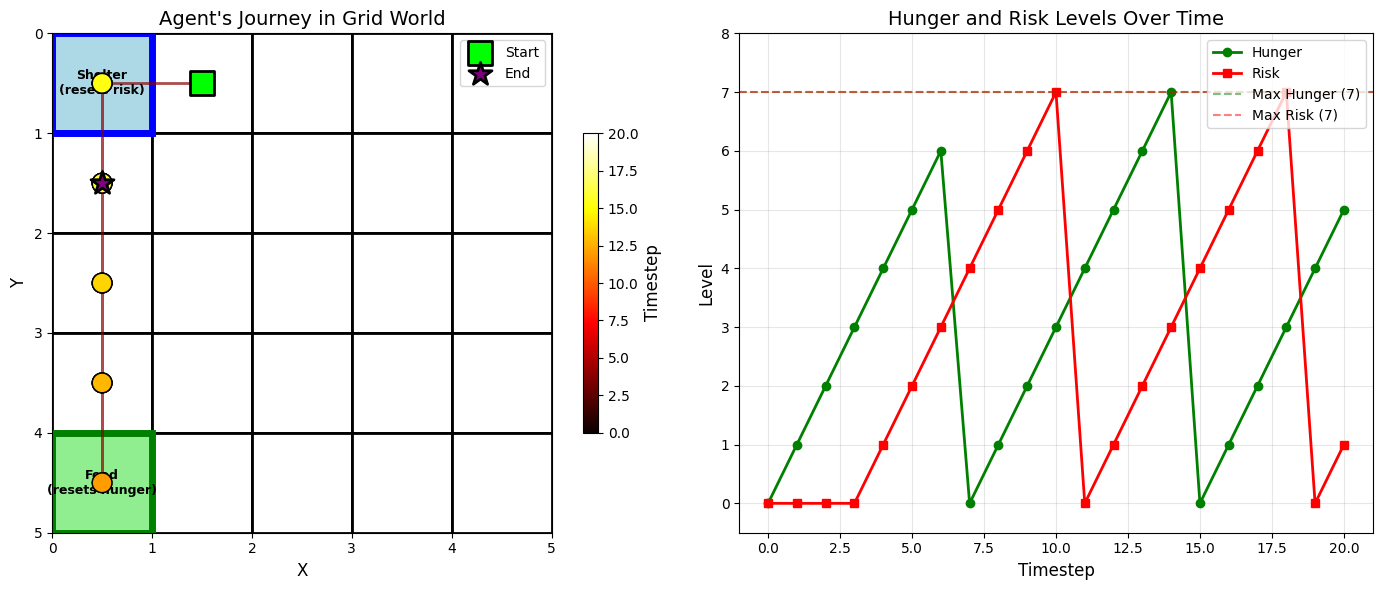


Journey Summary:
  Start: (0, 1), Hunger: 0, Risk: 0
  End: (1, 0), Hunger: 5, Risk: 1
  Total steps: 20
  Times at food: 2
  Times at shelter: 5


In [123]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
import numpy as np

# Convert history of locations to numpy array
all_locations = np.vstack(history_of_locs).astype(float)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Grid with agent path
ax = axes[0]

# Create grid with pcolormesh for the background
X, Y = np.meshgrid(np.arange(grid_dims[1]+1), np.arange(grid_dims[0]+1))
ax.pcolormesh(X, Y, np.ones(grid_dims), edgecolors='k', linewidth=2, facecolor='white')

# Draw grid squares
for y in range(grid_dims[0]):
    for x in range(grid_dims[1]):
        rect = patches.Rectangle((x, y), 1.0, 1.0, linewidth=2, 
                                  edgecolor='k', facecolor='white')
        ax.add_patch(rect)

ax.invert_yaxis()

# Mark food location (green)
food_rect = patches.Rectangle((food_location[1], food_location[0]), 1.0, 1.0, 
                               linewidth=5, edgecolor='green', facecolor='lightgreen')
ax.add_patch(food_rect)
ax.text(food_location[1]+0.5, food_location[0]+0.5, 'Food\n(resets hunger)', fontsize=9, 
        ha='center', va='center', fontweight='bold')

# Mark shelter location (blue)  
shelter_rect = patches.Rectangle((shelter_location[1], shelter_location[0]), 1.0, 1.0,
                                  linewidth=5, edgecolor='blue', facecolor='lightblue')
ax.add_patch(shelter_rect)
ax.text(shelter_location[1]+0.5, shelter_location[0]+0.5, 'Shelter\n(resets risk)', fontsize=9,
        ha='center', va='center', fontweight='bold')

# Plot the agent's path
ax.plot(all_locations[:,1]+0.5, all_locations[:,0]+0.5, 'darkred', linewidth=2, zorder=2, alpha=0.7)

# Color the dots by time
temporal_colormap = cm.hot(np.linspace(0, 0.8, len(all_locations)))
dots = ax.scatter(all_locations[:,1]+0.5, all_locations[:,0]+0.5, 200, 
                  c=temporal_colormap, zorder=3, edgecolors='black', linewidth=1)

# Mark start and end positions
ax.scatter(all_locations[0,1]+0.5, all_locations[0,0]+0.5, 300, c='lime', 
           marker='s', zorder=4, edgecolors='black', linewidth=2, label='Start')
ax.scatter(all_locations[-1,1]+0.5, all_locations[-1,0]+0.5, 300, c='purple',
           marker='*', zorder=4, edgecolors='black', linewidth=2, label='End')

sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=0, vmax=T))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
cbar.set_label('Timestep', fontsize=12)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlim(0, grid_dims[1])
ax.set_ylim(grid_dims[0], 0)
ax.set_aspect('equal')
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_title(f"Agent's Journey in Grid World", fontsize=14)

# Right plot: Hunger and Risk over time
ax2 = axes[1]
timesteps = np.arange(len(history_of_hunger))
ax2.plot(timesteps, history_of_hunger, 'g-o', label='Hunger', linewidth=2, markersize=6)
ax2.plot(timesteps, history_of_risk, 'r-s', label='Risk', linewidth=2, markersize=6)
ax2.axhline(y=max_hunger, color='g', linestyle='--', alpha=0.5, label=f'Max Hunger ({max_hunger})')
ax2.axhline(y=max_risk, color='r', linestyle='--', alpha=0.5, label=f'Max Risk ({max_risk})')
ax2.set_xlabel('Timestep', fontsize=12)
ax2.set_ylabel('Level', fontsize=12)
ax2.set_title('Hunger and Risk Levels Over Time', fontsize=14)
ax2.legend(loc='upper right')
ax2.set_ylim(-0.5, max(max_hunger, max_risk) + 1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print(f"\nJourney Summary:")
print(f"  Start: {history_of_locs[0]}, Hunger: {history_of_hunger[0]}, Risk: {history_of_risk[0]}")
print(f"  End: {history_of_locs[-1]}, Hunger: {history_of_hunger[-1]}, Risk: {history_of_risk[-1]}")
print(f"  Total steps: {len(history_of_locs)-1}")
print(f"  Times at food: {sum(1 for loc in history_of_locs if loc == food_location)}")
print(f"  Times at shelter: {sum(1 for loc in history_of_locs if loc == shelter_location)}")

# Experiment 2: Probabilistic Distance-Dependent Drives

In this experiment, we modify the environment and the agent's generative model to test probabilistic reward dynamics based on distance.

**Adjustments for Horizon**: To ensure the agent can "see" the reward within its policy horizon (length 5), we extend the probability field to 4 steps away. We also tweak the preferences (C matrix) slightly to make risk penalties steeper.

1.  **Opposite Locations**: Food and Shelter are now at opposite corners of the grid ((0,0) and (4,4)).
2.  **Probabilistic Updates**:
    *   **At target** (Distance 0): 100% chance of -1 drive.
    *   **1 step away** (Distance 1): 80% chance of -1 drive.
    *   **2 steps away** (Distance 2): 60% chance of -1 drive.
    *   **3 steps away** (Distance 3): 40% chance of -1 drive.
    *   **4 steps away** (Distance 4): 20% chance of -1 drive.
    *   **Far from target** (Distance > 4): 0% chance (always +1 drive).

This creates a longer "scent trail" that the agent can detect from the center of the grid.

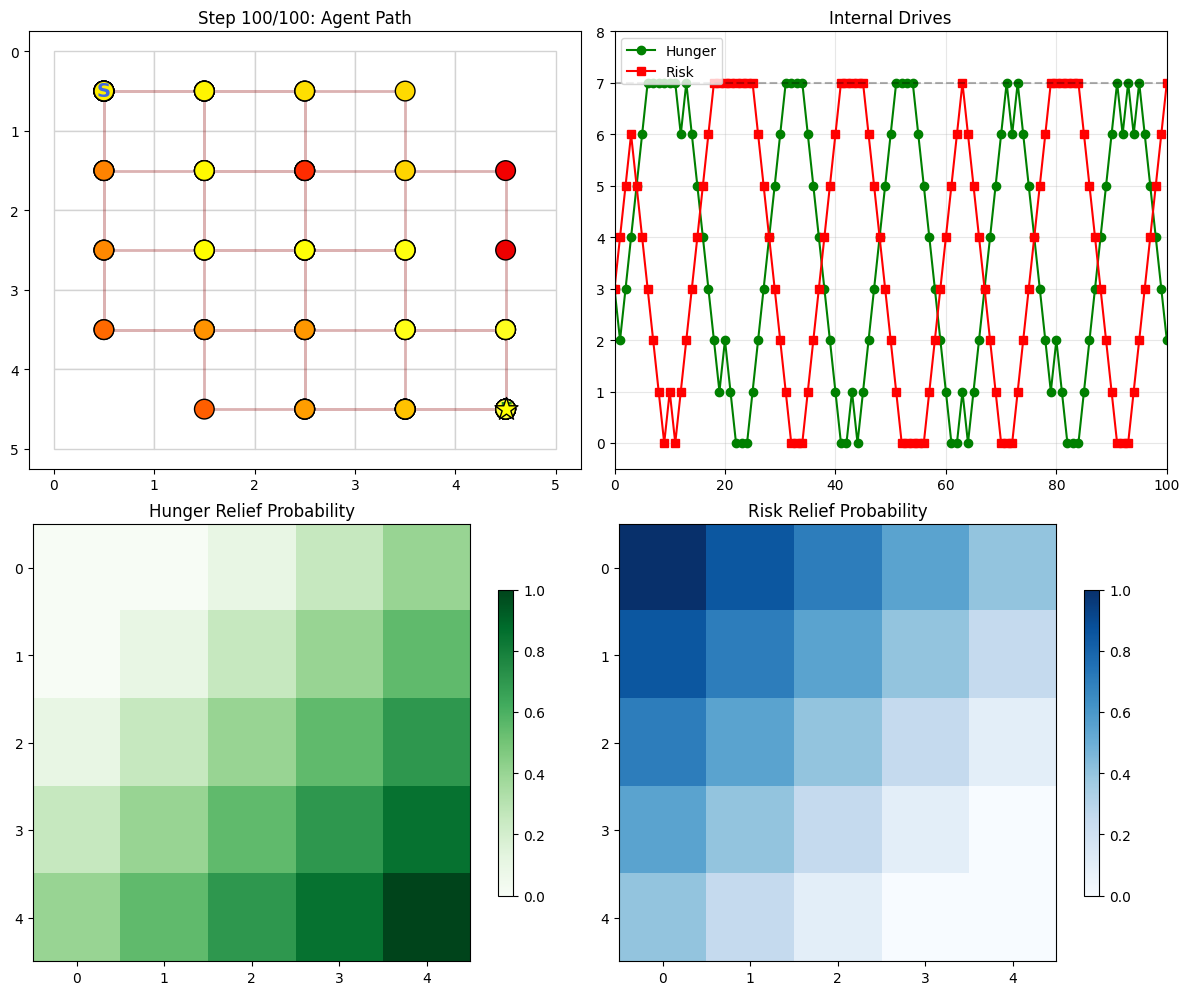

Experiment 2 Finished.


In [148]:
# === Experiment 2: Distance-Dependent Penalties ===

# 1. Start with same grid dimensions and max levels
# New locations: Opposite corners
food_location2 = (4, 4)      # Bottom-right
shelter_location2 = (0, 0)   # Top-left (unchanged)

# Pre-compute indices for new locations
food_idx2 = loc_list.index(food_location2)
shelter_idx2 = loc_list.index(shelter_location2)

print("Experiment 2 Setup:")
print(f"  Food: {food_location2}, Shelter: {shelter_location2}")

# 2. Define Custom Environment with "Spread Out" Penalties
class GridWorldEnvDistancePenalty(GridWorldEnv):
    def step(self, action_label):
        # Move agent
        super().step(action_label) # This updates self.current_location
        # But we need to override the hunger/risk update logic which was done in super().step()
        # Since super().step() already modified current_hunger/risk based on old logic, 
        # we need to recalculate them properly based on new logic.
        # Ideally we'd just reimplement the whole step method to avoid confusion.
        
        # Undo the hunger/risk update from super() step (a bit hacky, better to just copy logic)
        # Let's just re-implement the logic fully for clarity.
        
        # Recalculate movement (copying super logic for safety/simplicity of override)
        # Actually, self.current_location is already updated correctly by super(), 
        # we just need to correct the hunger/risk values.
        
        # Re-calculate correct hunger/risk based on new rules
        # We need the PREVIOUS hunger/risk to apply the delta correctly?
        # The prompt implies: "goes down/up X per turn". This is a Markov transition.
        # So we take the hunger value *before* the step and apply change?
        # Or just take the value stored in self.current_hunger (which might be wrong from super) and fix it?
        # Since super() does +1 or reset, it's destructive.
        # I MUST reimplement step completely to ensure correctness.
        pass

    # Re-implementing step fully to avoid inheritance issues with state updates
    def step(self, action_label):
        Y, X = self.current_location

        if action_label == "UP":
          Y_new = Y - 1 if Y > 0 else Y
          X_new = X
        elif action_label == "DOWN":
          Y_new = Y + 1 if Y < (self.grid_dims[0]-1) else Y
          X_new = X
        elif action_label == "LEFT":
          Y_new = Y
          X_new = X - 1 if X > 0 else X
        elif action_label == "RIGHT":
          Y_new = Y
          X_new = X + 1 if X < (self.grid_dims[1]-1) else X
        elif action_label == "STAY":
          Y_new, X_new = Y, X

        self.current_location = (Y_new, X_new)

        # Distance calculations
        dist_food = abs(self.current_location[0]-self.food_location[0]) + abs(self.current_location[1]-self.food_location[1])
        dist_shelter = abs(self.current_location[0]-self.shelter_location[0]) + abs(self.current_location[1]-self.shelter_location[1])

        # New Hunger Logic
        # Linear gradient to ensure "scent" is visible everywhere
        p_h = max(0.0, 1.0 - (dist_food * 0.15))
        
        if np.random.rand() < p_h:
            dh = -1
        else:
            dh = 1 # Natural increase if reward missed
            
        self.current_hunger = int(np.clip(self.current_hunger + dh, 0, self.max_hunger))

        # New Risk Logic
        p_r = max(0.0, 1.0 - (dist_shelter * 0.15))
            
        if np.random.rand() < p_r:
            dr = -1
        else:
            dr = 1
            
        self.current_risk = int(np.clip(self.current_risk + dr, 0, self.max_risk))

        # Observations
        loc_obs = self.current_location
        # Map values to closest available level if needed, but here levels are just integers
        hunger_obs = self.hunger_sensor_names[self.hunger_levels.tolist().index(self.current_hunger)]
        risk_obs = self.risk_sensor_names[self.risk_levels.tolist().index(self.current_risk)]

        return loc_obs, hunger_obs, risk_obs

# 3. New B Matrices with Distance-Based Transitions
B2 = utils.obj_array(len(num_states))

# B[0] (Location) - Same as before (Standard movement)
B2[0] = B[0].copy()

# B[1] (Hunger) - Distance dependent
B2[1] = np.zeros((num_hunger, num_grid_points, num_hunger, num_controls[1]))
print("Building B2[1] (Hunger)...")

for loc_idx in range(num_grid_points):
    curr_y, curr_x = loc_list[loc_idx]
    dist = abs(curr_y - food_location2[0]) + abs(curr_x - food_location2[1])
    
    # Linear gradient matching environment
    p_h = max(0.0, 1.0 - (dist * 0.15))
        
    for h in range(num_hunger):
        # Two possible outcomes:
        # 1. Reward (-1) with prob p_h
        # 2. No reward (+1) with prob 1-p_h
        
        next_h_dec = max(0, h - 1)
        next_h_inc = min(max_hunger, h + 1)
        
        if next_h_dec == next_h_inc: # Edge case if max_hunger=0? unlikely
             B2[1][next_h_dec, loc_idx, h, 0] = 1.0
        else:
            B2[1][next_h_dec, loc_idx, h, 0] += p_h
            B2[1][next_h_inc, loc_idx, h, 0] += (1.0 - p_h)

# B[2] (Risk) - Distance dependent
B2[2] = np.zeros((num_risk, num_grid_points, num_risk, num_controls[2]))
print("Building B2[2] (Risk)...")

for loc_idx in range(num_grid_points):
    curr_y, curr_x = loc_list[loc_idx]
    dist = abs(curr_y - shelter_location2[0]) + abs(curr_x - shelter_location2[1])
    
    # Linear gradient matching environment
    p_r = max(0.0, 1.0 - (dist * 0.15))
        
    for r in range(num_risk):
        next_r_dec = max(0, r - 1)
        next_r_inc = min(max_risk, r + 1)
        
        if next_r_dec == next_r_inc:
             B2[2][next_r_dec, loc_idx, r, 0] = 1.0
        else:
            B2[2][next_r_dec, loc_idx, r, 0] += p_r
            B2[2][next_r_inc, loc_idx, r, 0] += (1.0 - p_r)

# Verify B2
for i, b_fac in enumerate(B2):
    if not np.allclose(b_fac.sum(axis=0), 1.0):
        print(f"Warning: B2[{i}] not normalized!")

# 4. New A Matrices (Need to update for new food/shelter locations)
# A[0] is identity (same)
# A[1] and A[2] depend on specific locations
A2 = utils.obj_array(len(num_obs))
A2[0] = A[0].copy()

# A[1] Hunger
A2[1] = np.zeros((num_obs[1], num_grid_points, num_hunger, num_risk)) # Shapes same as before
for loc_idx in range(num_grid_points):
    for h in range(num_hunger):
        for r in range(num_risk):
            if loc_idx == food_idx2:
                A2[1][0, loc_idx, h, r] = 1.0 # Satiated at food
            else:
                A2[1][h, loc_idx, h, r] = 1.0 # True hunger elsewhere

# A[2] Risk
A2[2] = np.zeros((num_obs[2], num_grid_points, num_hunger, num_risk))
for loc_idx in range(num_grid_points):
    for h in range(num_hunger):
        for r in range(num_risk):
            if loc_idx == shelter_idx2:
                A2[2][0, loc_idx, h, r] = 1.0 # Safe at shelter
            else:
                A2[2][r, loc_idx, h, r] = 1.0 # True risk elsewhere

# 5. Run Simulation
initial_hunger2 = 3
initial_risk2 = 3
starting_loc2 = (2, 2) # Start in middle

my_env2 = GridWorldEnvDistancePenalty(
    starting_loc=starting_loc2,
    initial_hunger=initial_hunger2,
    initial_risk=initial_risk2,
    food_location=food_location2,
    shelter_location=shelter_location2,
    grid_dims=grid_dims,
    max_hunger=max_hunger,
    max_risk=max_risk,
    loc_list=loc_list,
    hunger_levels=hunger_levels,
    risk_levels=risk_levels,
    hunger_sensor_names=hunger_sensor_names,
    risk_sensor_names=risk_sensor_names
)

# Update Initial Belief D
D2 = utils.obj_array_uniform(num_states)
D2[0] = utils.onehot(loc_list.index(starting_loc2), num_grid_points)
D2[1] = utils.onehot(initial_hunger2, num_hunger)
D2[2] = utils.onehot(initial_risk2, num_risk)

# Tweak C to encourage leaving sooner (via EXPONENTIAL risk/hunger avoidance)
# KEY FIX: Remove positive rewards. "Satiated" and "Safe" should just be neutral (0.0).
# Having +10.0 reward for doing nothing (staying at food) makes it hard to leave.
# Also lower steepness so early risk levels (1, 2) are felt more strongly.
C[1][0] = 0.0 
C[2][0] = 0.0

penalty_approach2 = -30.0 # Stronger penalty
exp_steepness = 1.5      # Lower steepness = earlier pain (High steepness was hiding low risk)

# Risk Preferences (Factor 2)
if n_risk > 2:
    for i in range(1, n_risk - 1):
        denominator = (n_risk - 2) - 1
        progress = (i - 1) / denominator if denominator > 0 else 1.0
        
        # Exponential scaling: (e^(kx) - 1) / (e^k - 1)
        # Result: Low penalty for low risk, massive penalty for high risk
        scale = (np.exp(exp_steepness * progress) - 1) / (np.exp(exp_steepness) - 1)
        C[2][i] = penalty_approach2 * scale

# Hunger Preferences (Factor 1) - symmetrical
if n_hunger > 2:
    for i in range(1, n_hunger - 1):
        denominator = (n_hunger - 2) - 1
        progress = (i - 1) / denominator if denominator > 0 else 1.0
        
        # Exponential scaling
        scale = (np.exp(exp_steepness * progress) - 1) / (np.exp(exp_steepness) - 1)
        C[1][i] = penalty_approach2 * scale

# Agent
policy_len2 = 2
my_agent2 = Agent(A=A2, B=B2, C=C, D=D2, policy_len=policy_len2, 
                  B_factor_list=B_factor_list, control_fac_idx=control_fac_idx)

# Loop
from IPython.display import clear_output, display
import time

T2 = 100 # Increased duration to see oscillation
history_of_locs2 = [starting_loc2]
history_of_hunger2 = [initial_hunger2]
history_of_risk2 = [initial_risk2]
obs2 = my_env2.reset() 
obs2 = [loc_list.index(obs2[0]), hunger_sensor_names.index(obs2[1]), risk_sensor_names.index(obs2[2])]

# Pre-calculate Heatmaps for visualization efficiency
hunger_grid = np.zeros(grid_dims)
risk_grid = np.zeros(grid_dims)
for y in range(grid_dims[0]):
    for x in range(grid_dims[1]):
         d_f = abs(y - food_location2[0]) + abs(x - food_location2[1])
         hunger_grid[y, x] = max(0.0, 1.0 - (d_f * 0.15))
         d_s = abs(y - shelter_location2[0]) + abs(x - shelter_location2[1])
         risk_grid[y, x] = max(0.0, 1.0 - (d_s * 0.15))

print("\nStarting Experiment 2 Simulation...")

for t in range(T2):
    # --- Agent Step ---
    qs = my_agent2.infer_states(obs2)
    my_agent2.infer_policies()
    action_idx = int(my_agent2.sample_action()[0])
    action = actions[action_idx]
    
    loc_obs, hunger_obs, risk_obs = my_env2.step(action)
    
    obs2 = [loc_list.index(loc_obs), hunger_sensor_names.index(hunger_obs), risk_sensor_names.index(risk_obs)]
    
    history_of_locs2.append(loc_obs)
    history_of_hunger2.append(my_env2.current_hunger)
    history_of_risk2.append(my_env2.current_risk)

    # --- Live Visualization ---
    clear_output(wait=True)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Agent Path (Top Left)
    ax_path = axes[0, 0]
    ax_path.set_title(f"Step {t+1}/{T2}: Agent Path")
    ax_path.invert_yaxis()
    
    # Grid Background
    for y in range(grid_dims[0]):
        for x in range(grid_dims[1]):
            rect = patches.Rectangle((x, y), 1.0, 1.0, linewidth=1, edgecolor='lightgray', facecolor='white')
            ax_path.add_patch(rect)
    
    # Trajectory & Current Position
    hist_locs = np.vstack(history_of_locs2).astype(float)
    temporal_colormap = cm.hot(np.linspace(0, 0.8, len(hist_locs)))
    
    # Path line
    if len(hist_locs) > 1:
        ax_path.plot(hist_locs[:,1]+0.5, hist_locs[:,0]+0.5, 'darkred', linewidth=2, zorder=2, alpha=0.3)
    
    # Points
    ax_path.scatter(hist_locs[:,1]+0.5, hist_locs[:,0]+0.5, 200, c=temporal_colormap, zorder=3, edgecolors='black')
    
    # Current Head
    current_head = hist_locs[-1]
    ax_path.scatter(current_head[1]+0.5, current_head[0]+0.5, 300, c='yellow', marker='*', zorder=4, edgecolors='black', label='Current')

    # Markers
    ax_path.text(food_location2[1]+0.5, food_location2[0]+0.5, 'F', ha='center', va='center', fontweight='bold', color='forestgreen', fontsize=14)
    ax_path.text(shelter_location2[1]+0.5, shelter_location2[0]+0.5, 'S', ha='center', va='center', fontweight='bold', color='royalblue', fontsize=14)

    # 2. Stats (Top Right)
    ax_stats = axes[0, 1]
    ax_stats.set_title("Internal Drives")
    ax_stats.plot(history_of_hunger2, 'g-o', label='Hunger')
    ax_stats.plot(history_of_risk2, 'r-s', label='Risk')
    ax_stats.axhline(y=max_hunger, color='k', linestyle='--', alpha=0.3)
    ax_stats.set_xlim(0, T2)
    ax_stats.set_ylim(-0.5, max(max_hunger, max_risk)+1)
    ax_stats.legend(loc='upper left')
    ax_stats.grid(True, alpha=0.3)

    # 3. Hunger Map (Bottom Left)
    ax_map1 = axes[1, 0]
    ax_map1.set_title("Hunger Relief Probability")
    im1 = ax_map1.imshow(hunger_grid, cmap='Greens', vmin=0, vmax=1.0)
    fig.colorbar(im1, ax=ax_map1, shrink=0.7)
    
    # 4. Risk Map (Bottom Right)
    ax_map2 = axes[1, 1]
    ax_map2.set_title("Risk Relief Probability")
    im2 = ax_map2.imshow(risk_grid, cmap='Blues', vmin=0, vmax=1.0)
    fig.colorbar(im2, ax=ax_map2, shrink=0.7)
    
    plt.tight_layout()
    plt.show()

print("Experiment 2 Finished.")